# **Santander Customer Transaction Prediction**
A beginner's explanation.

# **INTRODUCTION**

This report provides a detailed explanation of a Python script used to train a binary classification model using LightGBM. We are referencing the development case by Kaggle user Giba for the competition called "Santander Customer Transaction Prediction". Links to the references can be found at the end of the notebook. This explanation is intended for beginners in data science, breaking down the workflow into understandable sections.



**Index**

1. Importing Libraries and Loading Data
2. Feature Selection and Transformation
3. Anomalous Rows Based on Frequencies
4. Preparation of Training Data
5. Model Training
6. Prediction on Test Set

# **1. Importing Libraries and Loading Data**

The script begins with the importation of several essential libraries for data processing, modeling, and manipulation of data structures. Subsequently, the training and test datasets are loaded. Due to the fact that Giba's development dates back five years and the updates to the libraries, we are importing two additional libraries which we will use and detail in section 6 'Model Training'.

In [4]:
# Libraries imported by Giba
import numpy as np
import pandas as pd
import gc
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from scipy.stats import rankdata

# NOT PART OF GIBA'S DEVELOPMENT: Libraries imported by us
from lightgbm import early_stopping, log_evaluation


In [5]:
# Importing Data
train_df = pd.read_csv("/content/drive/MyDrive/Proyectos Colab/santander-customer-transaction-prediction/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/Proyectos Colab/santander-customer-transaction-prediction/test.csv")

In [6]:
# NOT PART OF GIBA'S DEVELOPMENT:
train_df.tail()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
199995,train_199995,0,11.4880,-0.4956,8.2622,3.5142,10.3404,11.6081,5.6709,15.1516,...,6.1415,13.2305,3.9901,0.9388,18.0249,-1.7939,2.1661,8.5326,16.6660,-17.8661
199996,train_199996,0,4.9149,-2.4484,16.7052,6.6345,8.3096,-10.5628,5.8802,21.5940,...,4.9611,4.6549,0.6998,1.8341,22.2717,1.7337,-2.1651,6.7419,15.9054,0.3388
199997,train_199997,0,11.2232,-5.0518,10.5127,5.6456,9.3410,-5.4086,4.5555,21.5571,...,4.0651,5.4414,3.1032,4.8793,23.5311,-1.5736,1.2832,8.7155,13.8329,4.1995
199998,train_199998,0,9.7148,-8.6098,13.6104,5.7930,12.5173,0.5339,6.0479,17.0152,...,2.6840,8.6587,2.7337,11.1178,20.4158,-0.0786,6.7980,10.0342,15.5289,-13.9001
199999,train_199999,0,10.8762,-5.7105,12.1183,8.0328,11.5577,0.3488,5.2839,15.2058,...,8.9842,1.6893,0.1276,0.3766,15.2101,-2.4907,-2.2342,8.1857,12.1284,0.1385


In [7]:
# NOT PART OF GIBA'S DEVELOPMENT:
train_df.shape

(200000, 202)

In [8]:
# NOT PART OF GIBA'S DEVELOPMENT:
test_df.tail()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
199995,test_199995,13.1678,1.0136,10.4333,6.7997,8.5974,-4.1641,4.8579,14.7625,-2.7239,...,2.0544,9.6849,4.6734,-1.3660,12.8721,1.2013,-4.6195,9.1568,18.2102,4.8801
199996,test_199996,9.7171,-9.1462,7.3443,9.1421,12.8936,3.0191,5.6888,18.8862,5.0915,...,5.0071,6.6548,1.8197,2.4104,18.9037,-0.9337,2.9995,9.1112,18.1740,-20.7689
199997,test_199997,11.6360,2.2769,11.2074,7.7649,12.6796,11.3224,5.3883,18.3794,1.6603,...,5.1536,2.6498,2.4937,-0.0637,20.0609,-1.1742,-4.1524,9.1933,11.7905,-22.2762
199998,test_199998,13.5745,-0.5134,13.6584,7.4855,11.2241,-11.3037,4.1959,16.8280,5.3208,...,3.4259,8.5012,2.2713,5.7621,17.0056,1.1763,-2.3761,8.1079,8.7735,-0.2122
199999,test_199999,10.4664,1.8070,10.2277,6.0654,10.0258,1.0789,4.8879,14.4892,-0.5902,...,0.1398,9.2828,1.3601,4.8985,20.0926,-1.3048,-2.5981,10.3378,14.3340,-7.7094


In [9]:
# NOT PART OF GIBA'S DEVELOPMENT:
test_df.tail()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
199995,test_199995,13.1678,1.0136,10.4333,6.7997,8.5974,-4.1641,4.8579,14.7625,-2.7239,...,2.0544,9.6849,4.6734,-1.3660,12.8721,1.2013,-4.6195,9.1568,18.2102,4.8801
199996,test_199996,9.7171,-9.1462,7.3443,9.1421,12.8936,3.0191,5.6888,18.8862,5.0915,...,5.0071,6.6548,1.8197,2.4104,18.9037,-0.9337,2.9995,9.1112,18.1740,-20.7689
199997,test_199997,11.6360,2.2769,11.2074,7.7649,12.6796,11.3224,5.3883,18.3794,1.6603,...,5.1536,2.6498,2.4937,-0.0637,20.0609,-1.1742,-4.1524,9.1933,11.7905,-22.2762
199998,test_199998,13.5745,-0.5134,13.6584,7.4855,11.2241,-11.3037,4.1959,16.8280,5.3208,...,3.4259,8.5012,2.2713,5.7621,17.0056,1.1763,-2.3761,8.1079,8.7735,-0.2122
199999,test_199999,10.4664,1.8070,10.2277,6.0654,10.0258,1.0789,4.8879,14.4892,-0.5902,...,0.1398,9.2828,1.3601,4.8985,20.0926,-1.3048,-2.5981,10.3378,14.3340,-7.7094


In [10]:
# NOT PART OF GIBA'S DEVELOPMENT:
test_df.shape

(200000, 201)

**OBSERVATIONS**
- Both, train_df and test_df contain 200,000 rows of data and 200 feature columns (ranging from 0 to 199). Additionally, train_df includes a target column, which we aim to predict for the test_df dataset.

# **2. Feature Selection and Transformation**

A list called 'features' is created to contain all columns from 'train_df' that start with the string 'var'. This is to streamline the application of various functions throughout the current development.

In [11]:
features = [x for x in train_df.columns if x.startswith("var")]

The list will contain 200 entries (from var_0 to var_199), and the first five entries will look like this:

In [12]:
# NOT PART OF GIBA'S DEVELOPMENT:
features[:5] #

['var_0', 'var_1', 'var_2', 'var_3', 'var_4']

This code block calculates the Pearson correlation coefficients between each 'var' attribute and the target column 'target' in the 'train_df' DataFrame. If the correlation coefficient is negative, the 'var' attribute is multiplied by -1 in both train_df and test_df. This will standardize the direction of the relationships between the attributes and the target variable, ensuring that all attributes have a positive relationship with the target. **This standardization will facilitate model training**, as the relationships between the attributes and the target will be more consistent, enhancing model interpretation and efficiency.

In [13]:
# Reverse features transformation
for var in features:
    if np.corrcoef(train_df['target'], train_df[var])[1][0] < 0:
        train_df[var] = train_df[var] * -1
        test_df[var]  = test_df[var]  * -1

In [14]:
# NOT PART OF GIBA'S DEVELOPMENT: Here we can visualize the correlation between the target and the last 10 features, as well as the transformation in train_df
for var in features[-10:]:
    corr = np.corrcoef(train_df['target'], train_df[var])[1][0]
    print(f"Correlation coefficient between 'target' and {var}: {corr}")

Correlation coefficient between 'target' and var_190: 0.05597341401301761
Correlation coefficient between 'target' and var_191: 0.047113676868936985
Correlation coefficient between 'target' and var_192: 0.04285839935880052
Correlation coefficient between 'target' and var_193: 0.017709372898126578
Correlation coefficient between 'target' and var_194: 0.022837663876395232
Correlation coefficient between 'target' and var_195: 0.028284541775849745
Correlation coefficient between 'target' and var_196: 0.023607801875437318
Correlation coefficient between 'target' and var_197: 0.03530273786840072
Correlation coefficient between 'target' and var_198: 0.05299964136858094
Correlation coefficient between 'target' and var_199: 0.02543448356267697


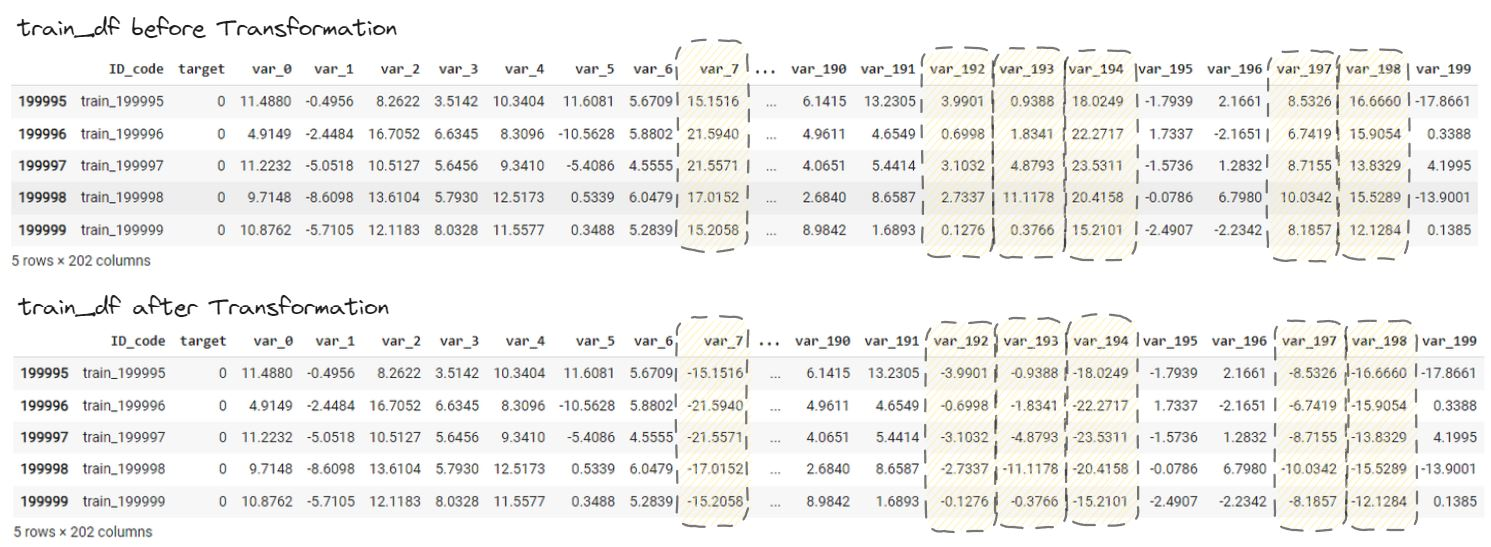

# **3. Anomalous Rows Based on Frequencies**

Here is an example of what this part of the code will do:

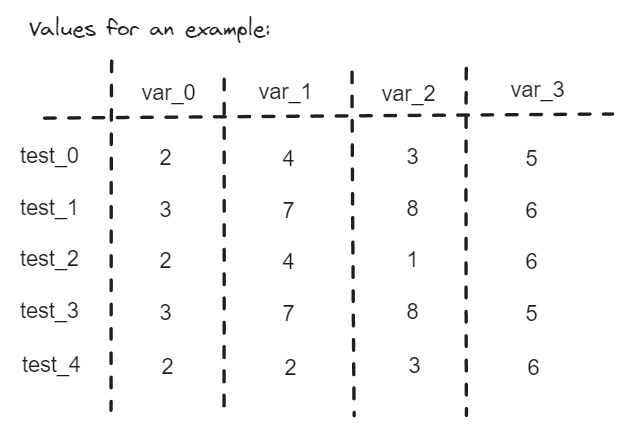

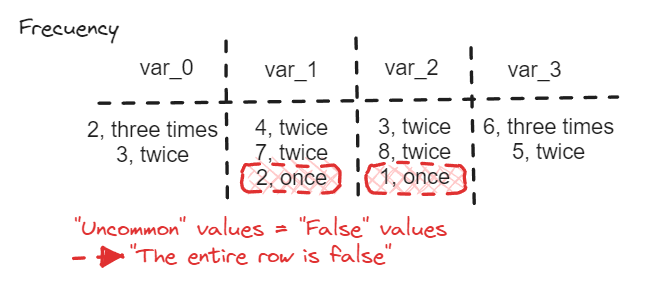

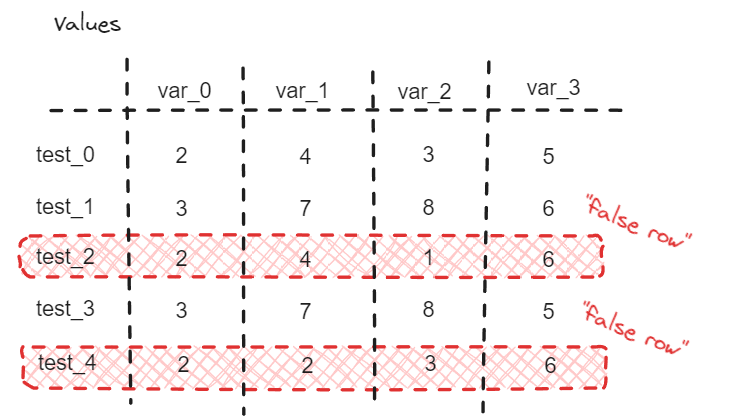

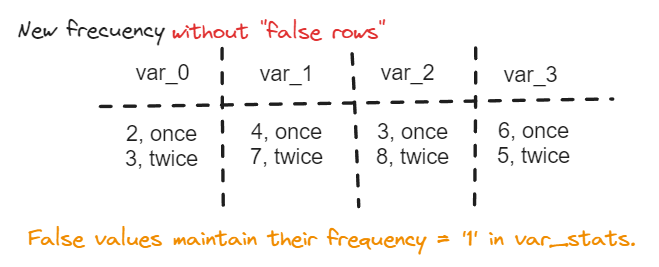

The objective of this process is to improve the integrity and quality of the dataset, ensuring that only valid and representative data add value to the predictive model, thereby enhancing the model's accuracy and reliability.

In this part of the code, the frequency of values is calculated to identify common values between the training and test sets. By mapping the frequencies and checking if they are greater than 1, we identify values that appear more than once. **If the frequency of a value is 1, it will be considered a 'False' value** (boolean data = '0' or 'False') and will be stored in the 'hist_df' DataFrame.

In [15]:
# Initialize dictionaries
var_stats = {}
hist_data = {}

# GIBA'S DEVELOPMENT:
## count all values
# var_stats = {}
# hist_df = pd.DataFrame()
# for var in features:
#    var_stats = train_df[var].append(test_df[var]).value_counts()
#    hist_df[var] = pd.Series(test_df[var]).map(var_stats)
#    hist_df[var] = hist_df[var] > 1
## remove fake test rows
# ind = hist_df.sum(axis=1) != 200

# NOT PART OF GIBA'S DEVELOPMENT: Since the 'APPEND' method in pandas is deprecated and throws an error, we use 'CONCAT' instead to concatenate DataFrames:
# Calculate frequencies and map values
for var in features:
    var_stats[var] = pd.concat([train_df[var], test_df[var]]).value_counts()
    hist_data[var] = pd.Series(test_df[var]).map(var_stats[var]) > 1

# Convert the dictionary to a DataFrame
hist_df = pd.DataFrame(hist_data)

# Classify "false" rows
ind = hist_df.sum(axis=1) != 200

In [16]:
# NOT PART OF GIBA'S DEVELOPMENT: Let's look at 'var_stats' for 'var_199'.
var_stats['var_199']

var_199
-10.5080    18
-0.2034     15
-5.6346     15
-10.7440    14
 8.1522     14
            ..
-0.5402      1
 3.9427      1
-4.2849      1
-9.2096      1
-7.7094      1
Name: count, Length: 197317, dtype: int64

We can see that the column 'var_199' has '-10.5080' as the most frequent value, appearing 18 times, and there are several values that only appear once. We will focus on '-7.7094', which is a value located in row '199999' of 'test_df' (this can be easily visualized with the 'tail' attribute).

In [17]:
# NOT PART OF GIBA'S DEVELOPMENT: Let's look at 'ind' which classifies rows as true if they have values that repeat only once
ind

0         False
1         False
2         False
3          True
4         False
          ...  
199995     True
199996     True
199997    False
199998    False
199999     True
Length: 200000, dtype: bool

As expected, row '199999' has a value of 'True' since it contains the value '-7.7094', which we previously saw is repeated only once in the 'var_199' column. Like this row, there are several others classified as 'True'. Here we have a visualization of the last 5 rows:

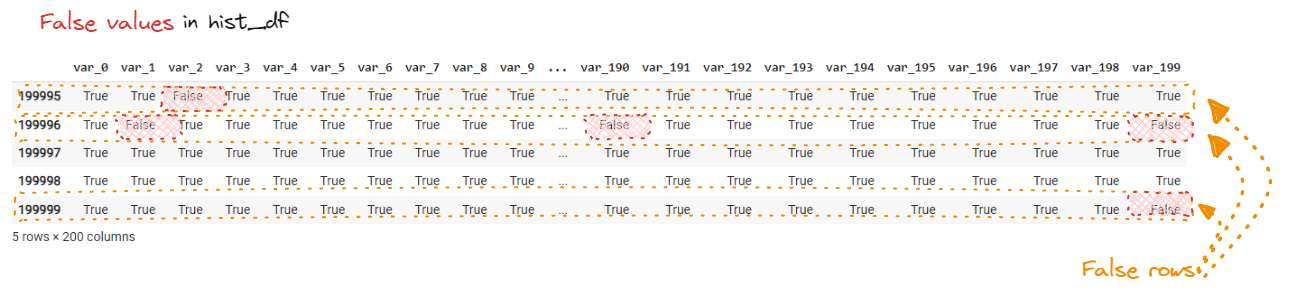

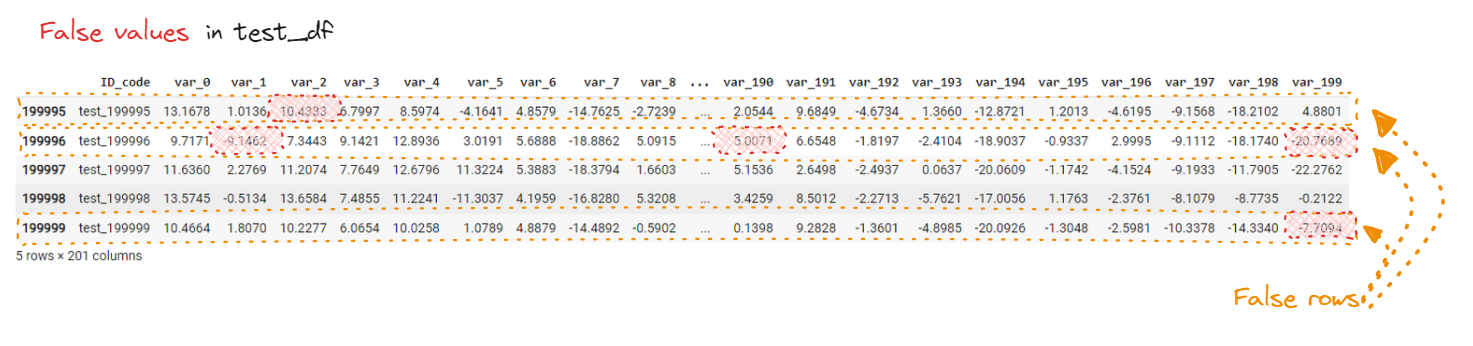

In [18]:
# Recount the frequencies without considering the false rows.
var_stats = {}
for var in features:
    var_stats[var] = pd.concat([train_df[var], test_df[ind][var]]).value_counts()


In [19]:
var_stats['var_199']

var_199
-13.7188    8
-6.4020     8
-1.4608     8
 3.9697     8
 4.2346     8
           ..
-0.5402     1
 3.9427     1
-4.2849     1
-9.2096     1
-7.7094     1
Name: count, Length: 197317, dtype: int64

Now we can see that the most frequent values have a maximum of 8 repetitions, not 18 as before removing the 'false' rows.

#**4. Preparation of Training Data**

This part of the code performs data preparation and feature normalization for a classification model. It defines functions to transform the variables and calculates essential statistics to normalize the features of the training set, preparing the data for modeling.

In [20]:
# Logit Transformation
def logit(p):
    return np.log(p) - np.log(1 - p)

The **logit transformation** is used to transform probabilities into a space where linear optimization algorithms can be applied.

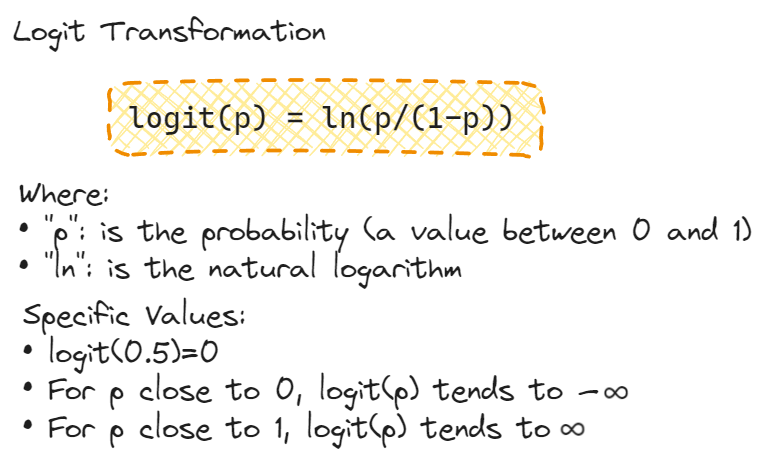

The **logit transformation function** will be useful when predicting the test set.

In [21]:
# Feature Transformation
def var_to_feat(vr, var_stats, feat_id ):
    new_df = pd.DataFrame()
    new_df["var"] = vr.values
    new_df["hist"] = pd.Series(vr).map(var_stats)
    new_df["feature_id"] = feat_id
    new_df["var_rank"] = new_df["var"].rank()/200000.
    return new_df.values

The **feature transformation function** (‘var_to_feat’) creates a new set of features that includes additional information derived from the variable ‘vr’ (these will be the original features from train_df[var] in the future).

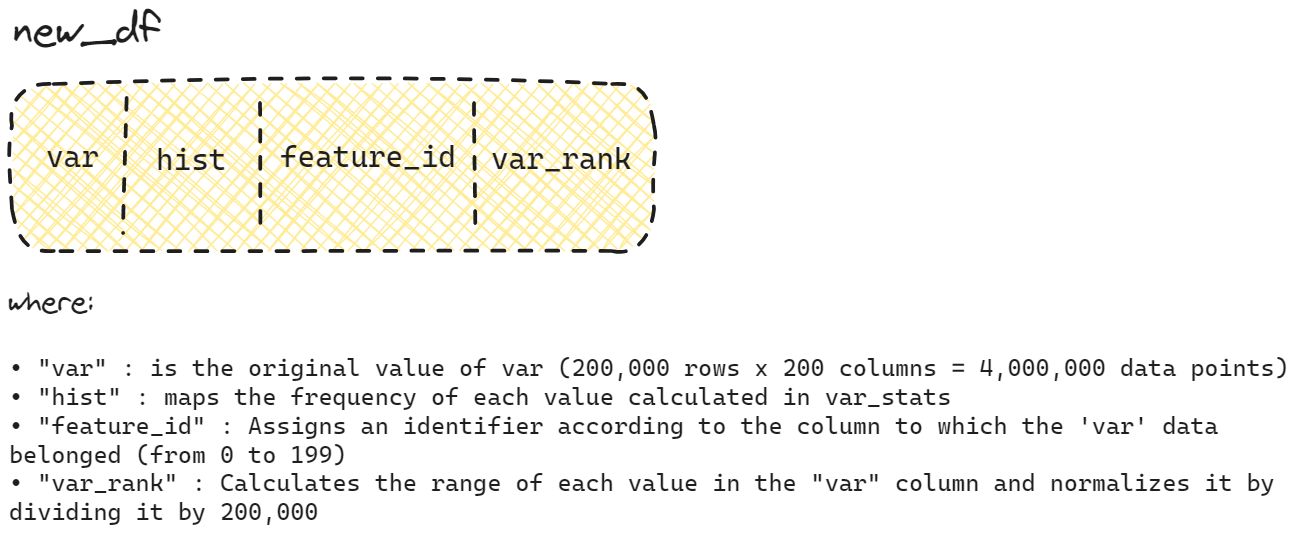

The **normalized range** is a way to represent the relative position of a value in the distribution of the variable. Normalization ensures that the ranges are within a fixed interval, which can improve the stability and performance of the model.

In [22]:
# Target set expansion
TARGET = np.array(list(train_df['target'].values) * 200 )

**Target set expansion** is a useful technique that replicates the target set to match the length of the feature set, allowing for the handling of multiple partitions during cross-validation. This facilitates the training and evaluation process in procedures involving multiple models or training iterations.

In [23]:
# NOT PART OF GIBA'S DEVELOPMENT:
train_df.shape

(200000, 202)

In [24]:
# NOT PART OF GIBA'S DEVELOPMENT:
TARGET.shape

(40000000,)

Since we will be using **LightGBM**, it is crucial to normalize all values to achieve better performance in terms of accuracy and training speed. In this part of the code, we ensure that the data is in an appropriate form and **ready for model training**.

In [25]:
# Feature Transformation and Normalization
TRAIN = []
var_mean = {}
var_var  = {}
for var in features:
    tmp = var_to_feat(train_df[var], var_stats[var], int(var[4:]) )
    var_mean[var] = np.mean(tmp[:,0]) # Mean of the values in the first column (‘vr’)
    var_var[var]  = np.var(tmp[:,0]) # Variance of the values in the first column (‘vr’)
    tmp[:,0] = (tmp[:,0]-var_mean[var])/var_var[var] # Normalization of the values (subtract the mean and divide by the variance)
    TRAIN.append( tmp ) # Add the transformed DataFrame 'tmp' to the 'TRAIN' list
TRAIN = np.vstack( TRAIN ) # Convert the list of transformed DataFrames TRAIN into a NumPy array by vertically stacking the DataFrames.

print( TRAIN.shape, len( TARGET ) )

(40000000, 4) 40000000


In [26]:
# NOT PART OF GIBA'S DEVELOPMENT:
TRAIN[:5]

array([[-0.1898334 ,  8.        ,  0.        ,  0.3043175 ],
       [ 0.0888009 ,  3.        ,  0.        ,  0.6147625 ],
       [-0.22404728,  6.        ,  0.        ,  0.2677275 ],
       [ 0.04116981,  3.        ,  0.        ,  0.563675  ],
       [-0.09121692,  8.        ,  0.        ,  0.415205  ]])

In [27]:
# Memory Release
del train_df
_=gc.collect()

# **5. Model Training**

GIBA's solution was created five years ago, which, when we attempt to apply his code today, generates **compatibility issues** with our version of LightGBM. We encounter this problem in this part of the code when attempting to set the 'early_stopping_rounds' and 'verbose' parameters, which throws an error. Therefore, we have adopted the use of **Callbacks**, which is a more robust practice and allows for better control of the training stages.


In this part of the code, we define the model **'LGBMClassifier'** with a series of specific hyperparameters (as defined in GIBA's solution). We will use **Stratified Cross-Validation** with **'StratifiedKFold**' to create 10 stratified folds, ensuring that each fold has the same proportion of target classes. The model will be trained on each fold of the cross-validation, using the specific training and validation data for that fold. The **'AUC'** metric is also used to evaluate the performance on the validation set, and early stopping is employed to halt training if performance does not improve after 25 rounds (This prevents overfitting when the validation set stops improving).

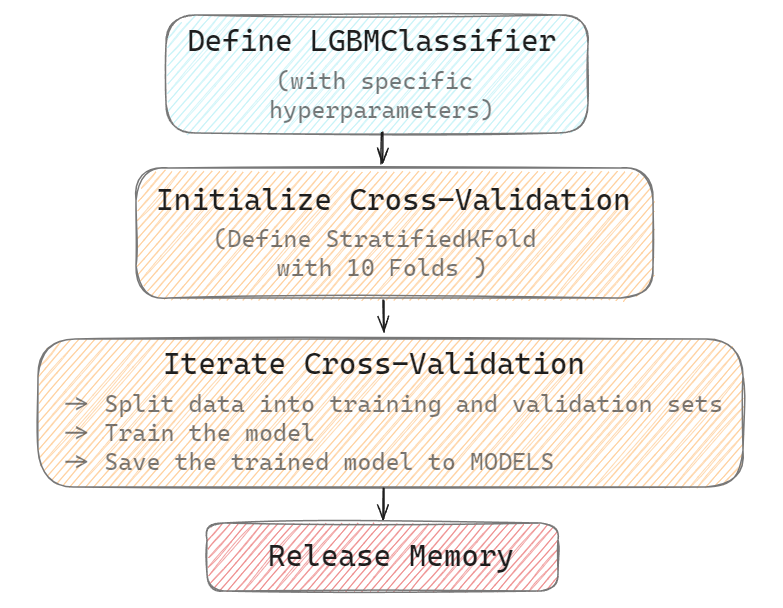

In [28]:
# Hyperparameters defined by GIBA
model = lgb.LGBMClassifier(
    learning_rate=0.04,
    num_leaves=31,
    max_bin=1023,
    min_child_samples=1000,
    reg_alpha=0.1,
    reg_lambda=0.2,
    feature_fraction=1.0,
    bagging_freq=1,
    bagging_fraction=0.85,
    objective='binary',
    n_jobs=-1,
    n_estimators=200
)


MODELS = []

# Stratified Cross-Validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=11111)

# Callbacks
callbacks = [
    early_stopping(stopping_rounds=25),
    log_evaluation(10)
]

# Iterate the model over each fold of cross-validation and add the trained model to MODELS
for fold_, (train_indexes, valid_indexes) in enumerate(skf.split(TRAIN, TARGET)):
    print('Fold:', fold_)
    model.fit(
        TRAIN[train_indexes], TARGET[train_indexes],
        eval_set=[(TRAIN[valid_indexes], TARGET[valid_indexes])],
        eval_metric='auc',
        callbacks=callbacks,
        categorical_feature=[2]
    )
    MODELS.append(model)

# Memory Release
del TRAIN, TARGET
_ = gc.collect()

# NOT PART OF GIBA'S DEVELOPMENT: Verify the number of trained models
print(f'Number of models trained: {len(MODELS)}')

Fold: 0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 3617640, number of negative: 32382360
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.408165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_

# **6. Prediction on Test Set**

Finally, this section of the code is dedicated to generating the final predictions for the test set using the previously trained **LightGBM ensemble** model through stratified cross-validation.

In [30]:
# Initialize Cross-Validation
ypred = np.zeros( (200000,200) )
# Iterate Cross-Validation
for feat,var in enumerate(features):
    tmp = var_to_feat(test_df[var], var_stats[var], int(var[4:]) )
    tmp[:,0] = (tmp[:,0]-var_mean[var])/var_var[var]
    # Prediction using each mode
    for model_id in range(10):
        model = MODELS[model_id]
        ypred[:,feat] += model.predict_proba( tmp )[:,1] / 10.
# Calculation of the mean predictions
ypred = np.mean( logit(ypred), axis=1 )

# Preparation of the submission file
sub = test_df[['ID_code']]
sub['target'] = ypred
sub['target'] = sub['target'].rank() / 200000.
sub.to_csv('golden_sub.csv', index=False)
print( sub.head(10) )

Se han truncado las últimas 5000 líneas del flujo de salida.
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM]

<ipython-input-30-a4429f381636>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['target'] = ypred
<ipython-input-30-a4429f381636>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['target'] = sub['target'].rank() / 200000.


  ID_code    target
0  test_0  0.820595
1  test_1  0.874110
2  test_2  0.871395
3  test_3  0.826150
4  test_4  0.730300
5  test_5  0.068385
6  test_6  0.087105
7  test_7  0.603815
8  test_8  0.064595
9  test_9  0.149190


The approach of averaging the predictions from multiple models trained in cross-validation is an effective way to assemble models, significantly improving the performance and robustness of the final model. Additionally, aggregating predictions from multiple features and models helps to mitigate the risk of overfitting and better capture the variability of the data.

As a final result, the values of **‘sub[‘target’]’** indicate the probability that the observation contains the value ‘1’ (considering that the target in the training set consisted of boolean values of 0 or 1).

# **References**:

- Kaggle competintion detail: https://www.kaggle.com/competitions/santander-customer-transaction-prediction/overview
- Notebook: https://www.kaggle.com/code/titericz/giba-single-model-public-0-9245-private-0-9234
- Giba's profile on Kaggle: https://www.kaggle.com/titericz